# Proof of Concept

This notebook demonstrates the full pipeline implemented in the package, illustrating a potential use case in the absence of real data.

1. A synthetic framework (i.e., an annotated dataset) is first generated.
2. A BERT classifier is then trained on the synthesized data. 
3. Next, an interaction is simulated between two agents representing a 'student' and a 'tutor'.
4. The trained classifier is then applied to the simulated conversation. In this case, both agents' outputs are analyzed.
5. Finally, the classified data is presented in a descriptive format, showcasing how results might be reported in a real-world scenario.

In [2]:
import sys
sys.path.insert(0, '/Users/dklaupaa/Desktop/chat_wrap_package/src') 

In [3]:
import os

import pandas as pd
import yaml

os.getcwd()

'/Users/dklaupaa/Desktop/chat_wrap_package'

## 1. Generate Synthetic Framework 

In [4]:
from educhateval.core import FrameworkGenerator

In [6]:
generator = FrameworkGenerator(model_name="llama-3.2-3b-instruct", api_url="http://localhost:1234/v1/completions")

In [8]:
# Generate a framework with 4 types of prompts
df_yaml = generator.generate_framework(
    prompt_path="data/templates/prompt_intent_4types.yaml", 
    num_samples=5#, 
    #csv_out="data/generated_tuning_data/synth_default_fourtypes.csv"
)

Generating for category: Clarification
Generating for category: Small Talk
Generating for category: Question
Generating for category: Statement
Number of duplicates removed: 0


In [9]:
df_yaml

,text,category
0,It seems like you're seeking clarification on ...,Clarification
1,It seems like you're asking for a summary of t...,Clarification
2,The text I provided is about a new research pr...,Clarification
3,The text is about a new research paper that yo...,Clarification
4,"You're rephrasing the original question, which...",Clarification
5,How's your day going so far?,Small Talk
6,How's the weather treating you today?,Small Talk
7,"So, how was your weekend? Do anything exciting?",Small Talk
8,Do you have any fun plans for the day?,Small Talk
9,How was your weekend? Do anything exciting?,Small Talk


### 1.1. Generate the Framework by Stored Prompts

The framework is generated using a prompt stored in `src/framework_generation/outline_prompts/prompt_default_4types.py`. Alternatively, a dictionary of prompts can be provided directly—see the example in section 1.2.

The synthetic data is generated using a language model hosted locally via LM Studio. To use this setup, download the model to your local machine and run it through the LM Studio server. Instructions are available here: [LM Studio API Docs](https://lmstudio.ai/docs/app/api). 

In this use case the output is saved as a CSV file, but it can also be returned as a pandas DataFrame or stored in JSON format, depending on your needs.

In [4]:
# Load the generator with the specified model and API URL
generator = FrameworkGenerator(model_name="llama-3.2-3b-instruct", api_url="http://localhost:1234/v1/completions")

In [ ]:
# Generate a framework with 4 types of prompts
df_4 = generator.generate_framework(
    prompt_path="src/educhateval/framework_generation/outline_prompts/prompt_default_4types.py", 
    num_samples=500, 
    csv_out="data/generated_tuning_data/synth_default_fourtypes.csv"
)

Generating for category: Clarification
Skipping invalid output for category 'Clarification': 'choices'
Generating for category: Small Talk
Generating for category: Question
Generating for category: Statement
Number of duplicates removed: 617
→ Saved CSV: data/generated_tuning_data/synth_default_fourtypes.csv


In [30]:
# Examples and length of each category
for category in df_4['category'].unique():
    print(f"\nCategory: {category}")
    print(f"Count: {len(df_4[df_4['category'] == category])}")
    print(df_4[df_4['category'] == category].sample(3))


Category: Clarification
Count: 478
                                                  text       category
392   Can you please rephrase or break it down for me?  Clarification
135  I'm not sure I follow, could you provide more ...  Clarification
359  I think I need more context, can you provide a...  Clarification

Category: Small Talk
Count: 208
                                                  text    category
603    Is your commute getting more challenging today?  Small Talk
891  Are you from around here? I love exploring new...  Small Talk
723      I'm glad I ran into you. What's new with you?  Small Talk

Category: Question
Count: 265
                                                   text  category
1165     What is the meaning of the word "sentimental"?  Question
1199  Can humans survive on a deserted island with l...  Question
1034  What are the main differences between Buddhism...  Question

Category: Statement
Count: 431
                                                   text 

The smaller numbers for some categories are an result of duplicates being removed.

#### 1.1.1 Example Using a Dictionary: 
While this data isn't used in the analysis, it is an example of how users can prompt the generator directly with a very simple system prompt with no examples. 
It is worth emphasizing that typically the better the prompting, the better the quality of data. Hence a more nuanced prompt may be required. Look in the abovementioned .py for inspiration.

In [ ]:
custom_prompt_dict = {
    "Weather Example": """<|im_start|>system
You are a helpful assistant that answers provides information about the weather. Please provide fictional weather-related information.
<|im_end|>"""

}

# run with direct dict and save as df
df_direct_dict = generator.generate_framework(
    prompt_dict_input=custom_prompt_dict,
    num_samples=5
)

Generating for category: Weather Example
Number of duplicates removed: 0


In [ ]:
# printing the beginning (until dot) of 3 random examples of the generated text
print("\nRandom examples from the generated text:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(df_direct_dict.iloc[i]['text'].split('.')[0])


Random examples from the generated text:

Example 1:
I'm happy to help! Here's the latest weather forecast:

**Current Weather:** A beautiful day is unfolding across the country, with plenty of sunshine and mild temperatures

Example 2:
The forecast for tomorrow is looking good! A warm front will bring clear skies and mild temperatures, with highs in the mid-60s to low 70s

Example 3:
The temperature and humidity level are still quite high in the city today


### 1.2: Quality Check of Data
The generated data is quality-checked by training a small model from Hugging Face using a few-shot learning approach. The user must create a labeled dataset containing approximately 10 examples per category in a `csv` or `json` format. This dataset is used to train the model.

Both the model, tokenizer, and training data can be stored for future use, if desired. The final stored dataset consists of the examples where both the generative model (from section 1.1) and the trained classifier predict the same label.
If the user is interested in hyperparameter tuning, `tuning` should be set to `True`, and a grid of training parameters must be provided as a dictionary to `tuning_params`. If no parameters are specified, the model is trained using the following default settings: 

```
default_tuning_params = {
    "dropout_rate": 0.01,
    "loss_function": "cross_entropy",
    "learning_rate": 5e-5,the
    "batch_size_train": 8,
    "batch_size_eval": 8,
    "num_epochs": 4,
    "weight_decay": 0.01
}
```


In [31]:
filtered_df = generator.filter_with_classifier(
    train_data="data/generated_tuning_data/tiny_labeled_default.csv", # the labeled data used for training the classifier provided by user
    synth_data="data/generated_tuning_data/synth_default_fourtypes.csv", # the synthesized data generated above (the pandas df can also be used here)
    classifier_model_name = "distilbert-base-uncased", # huggingface model name
    filtered_save_path="data/generated_tuning_data/final_qual_default.csv" # output path for storage   
)

Max token: 34 Average token: 16.181818181818183


Map: 100%|██████████| 14/14 [00:00<00:00, 7121.06 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/dklaupaa/Library/Caches/pypoetry/virtualenvs/chat-wrap-package-h94m8WQz-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/dklaupaa/Library/Caches/pypoetry/virtualenvs/chat-wrap-package-h94m8WQz-py3.12/lib/python3.12/site-packages/transformers/training_args.py:2262: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by defau

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.254566,0.428571,0.187500,0.428571,0.259740
2,No log,1.051690,0.857143,0.914286,0.857143,0.857143
3,No log,0.912623,0.857143,0.914286,0.857143,0.863889
4,No log,0.858294,0.857143,0.914286,0.857143,0.863889


/Users/dklaupaa/Library/Caches/pypoetry/virtualenvs/chat-wrap-package-h94m8WQz-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Map: 100%|██████████| 1382/1382 [00:00<00:00, 14771.91 examples/s]


Filtered data saved to data/generated_tuning_data/final_qual_default.csv


In [37]:
# Examples and length:
filtered_df_dp = filtered_df.drop(columns=['label_id', 'predicted'])
for category in filtered_df_dp['category'].unique():
    print(f"\nCategory: {category}")
    print(f"Count: {len(filtered_df_dp[filtered_df_dp['category'] == category])}")
    print(filtered_df_dp[filtered_df_dp['category'] == category].sample(3))

    


Category: Clarification
Count: 433
                                                  text       category
470  Can you rephrase or provide more context to he...  Clarification
83       Could you rephrase the question or statement?  Clarification
200  I see what you're saying, but I'm not sure how...  Clarification

Category: Small Talk
Count: 155
                                                  text    category
549     How was your weekend, did you do anything fun?  Small Talk
616  So, what's new with you? Any exciting plans or...  Small Talk
659  I love the new shoes you're wearing. Where did...  Small Talk

Category: Question
Count: 245
                                                  text  category
855  What are the three main components of the proc...  Question
913  What are the benefits of regular exercise on m...  Question
909  How do trees adapt to changing environmental c...  Question

Category: Statement
Count: 428
                                                   text   ca

Now a quality checked  training dataset has been synthesized.

## 2. Generate Synthetic Tutor/Student Interaction 
In this step, a dialogue is synthesized between two agents. A single Hugging Face model (either MLX or the standard Hugging Face format) is used as the generator behind both the 'student' and 'tutor' agents.

The interaction setup is determined by system prompts assigned to each agent. These prompts are defined in a user-created `.yaml` file tailored to the specific use case. By default, a general problem-solving mode is used: the student is prompted to act as a learner tackling an educational task of their own choosing, while the tutor is prompted to assist in solving it. Examples of prompts can be found here: `src/dialogue_generation/txt_llm_inputs/system_prompts.yaml`. In the function the `mode` is set to match the wanted system prompt in the file. 

While this step could be omitted in a real-world pipeline—since the goal is to analyze *human* interactions with chatbots rather than chatbot-to-chatbot exchanges—it is included here to (1) generate sufficient data for completing the pipeline and carrying out the full analysis and (2) demonstrate how synthetic interaction data can be created in cases where real conversations are unavailable or impractical to collect.

In [1]:
import sys
sys.path.insert(0, '/Users/dklaupaa/Desktop/chat_wrap_package/src') 

In [2]:
from educhateval.core import DialogueSimulator
from pathlib import Path

In [3]:
#simulator = DialogueSimulator(backend="hf", model_id="meta-llama/Llama-3.2-1B-Instruct")
simulator = DialogueSimulator(backend="mlx", model_id="mlx-community/Qwen2.5-7B-Instruct-1M-4bit")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

#### 2.1 Generating Interactions

The student agent has a default seed message: "*Hi, I'm a student seeking assistance with my studies*." However, a custom seed message can be provided to simulate a specific type of interaction or contextual scenario—for example, by specifying a particular task or subject.

In this simulation example, three different datasets are created—one for an English course, one for a Biology course, and one for learning Spanish. Each dataset consists of 30 unique student interactions, with each student receiving 1 of 5 different seed messages. This approach mimics how users might have varying use cases for the application or want to test hypotheses about interaction patterns across different educational contexts.

In [ ]:
# example: dictionary of system prompts, same as defautl
custom_prompts = {
    "conversation_types": {
        "general_task_solving": {
            "student": "You are a student asking for help with a task.",
            "tutor": "You are a helpful tutor guiding the student step by step."
        },
    }
}

system_prompts = custom_prompts["conversation_types"]["general_task_solving"]


In [8]:
# Example of how to simulate one dialogue
seed_message = "Hi, I'm a student seeking assistance with my studies in English." # example input - same as default

df_single = simulator.simulate_dialogue(
    mode="general_task_solving", 
    #system_prompts=system_prompts,
    turns=4,
    seed_message_input=seed_message,
    custom_prompt_file=Path("src/educhateval/dialogue_generation/txt_llm_inputs/system_prompts.yaml")
)


--- Starting Dialogue Simulation ---

[Student]: Hi, I'm a student seeking assistance with my studies in English.
[Tutor]: Hi! I'm here to help. What specific English topic or problem would you like assistance with?

Turn 2:
[Student]: Could you please provide an example of the type of English problem or question I should be focusing on?
[Tutor]: Sure! Try focusing on something like improving your essay writing, grammar, or vocabulary. What area of English are you finding challenging?

Turn 3:
[Student]: Could you give me an example of a grammar problem I might be having trouble with?
[Tutor]: Of course! How about this: Identify the correct tense to use in the sentence: "I ______ the garden yesterday." (Options: A) have planted, B) will plant, C) planted)

Turn 4:
[Student]: Could you please explain why "planted" is the correct answer for the sentence: "I ______ the garden yesterday"?
[Tutor]: "Planted" is correct because it uses the simple past tense, which is used for actions comple

Now lets do it for 90 'students', 30 in each course with course specific seeds

In [ ]:
n_students_per_course = 30 # kind of like in a classroom 

# Load YAML file with seed messages
with open("src/dialogue_generation/txt_llm_inputs/student_seed_messages.yaml", "r") as f:
    seed_messages = yaml.safe_load(f)

# Displaying examples of seed messages
for course_name, course_content in seed_messages.items():
    seeds = course_content.get("seeds", [])
    print(f"\nCourse: {course_name}")
    print(f"Number of seeds: {len(seeds)}")
    print("Seed messages:")
    for seed in seeds:
        print(seed)



Course: english_course
Number of seeds: 5
Seed messages:
Hi, I'm struggling with writing essays. Can you help me improve?
Hi, Can you explain how to use the passive voice in English?
Hi, I'm preparing for an English exam—what are common grammar mistakes to watch out for?
Hi, How can I expand my vocabulary effectively?
Hi, Can you help me analyze this short story for class?

Course: biology_course
Number of seeds: 5
Seed messages:
Hi, I'm having trouble understanding cell division. Can you explain mitosis vs meiosis?
Hi, Can you help me review the parts of a plant cell?
Hi, How does natural selection work in evolution?
Hi, I need help with a biology lab report on photosynthesis.
Hi, What’s the difference between DNA and RNA?

Course: spanish_course
Number of seeds: 5
Seed messages:
Hi, I’m learning Spanish and need help practising.
Hi, how do I use past tense verbs in Spanish?
Hi, can you help me practice a short dialogue in Spanish?
Hi, what are some tips for improving Spanish pronunc

In [15]:
course_dfs = {}

# Loop through each course and simulate dialogues
for course_name, course_content in seed_messages.items():
    seeds = course_content.get("seeds", [])
    n_seeds = len(seeds)
    all_course_dialogues = []

    for student_index in range(n_students_per_course):
        # Select seed message in round-robin fashion
        seed_message = seeds[student_index % n_seeds]

        df_single = simulator.simulate_dialogue(
            mode="general_task_solving",
            turns=8, # Should be adjusted if there is any assumption about the number of turns
            seed_message_input=seed_message
        )

        # Add student ID and course info
        df_single["student_id"] = f"{course_name}_student_{student_index+1}"
        df_single["course"] = course_name

        all_course_dialogues.append(df_single)

    # Combine into one dataframe per course
    course_df = pd.concat(all_course_dialogues, ignore_index=True)
    course_dfs[course_name] = course_df

# Access the dataframes
biology_df = course_dfs["biology_course"]
english_df = course_dfs["english_course"]
spanish_df = course_dfs["spanish_course"]



--- Starting Dialogue Simulation ---

[Student]: Hi, I'm struggling with writing essays. Can you help me improve?
[Tutor]: Absolutely! Let's start by focusing on structuring your essays: introduction, body paragraphs, and conclusion. Want to practice the introduction first?

Turn 2:
[Student]: Sure, let's start with the introduction. Could you give me an example of an essay topic so I can practice writing a good introduction?
[Tutor]: Sure! How about this topic: "The Impact of Social Media on Mental Health."

Good intro starts strong. Try this outline:
1. Grab attention with a surprising fact or question.
2. Briefly mention the topic.
3. State your thesis clearly.

Start with something like: "Did you know social media usage has doubled in the last decade? This growth raises serious concerns about its impact on mental health."

Turn 3:
[Student]: Got it! So for my introduction, I should start with a surprising fact or question, then mention the topic, and end with a clear thesis statem

In [21]:
# print duplicates messages if any where turn is not 1
duplicates = []
for course_name, course_df in course_dfs.items():
    duplicates_course = course_df[course_df.duplicated(subset=['student_msg'], keep=False) & (course_df['turn'] != 1)]
    duplicates.append(duplicates_course)

# make into one df
duplicates_df = pd.concat(duplicates, ignore_index=True)
duplicates_df


,turn,student_msg,tutor_msg,student_id,course
0,7,Great! Thanks for the clarification.,You're welcome! Glad to help.,english_course_student_3,english_course
1,6,Great! Thanks for the clarification.,You're welcome! Happy learning!,english_course_student_19,english_course
2,3,Could you give me another example to practice ...,"Sure! Try: ""Me llamo María.""",spanish_course_student_1,spanish_course
3,5,Could you give me another example to practice ...,"Of course! Try: ""Él es Juan.""",spanish_course_student_1,spanish_course


This indicates that each interaction between agents is almost entirely unique, despite the use of similar seed messages, as evidenced by the very few generic repetitions observed above.

In [16]:
# Saving the dataframes to CSV files
biology_df.to_csv("data/generated_dialogue_data/synth_biology_interaction.csv", index=False)
english_df.to_csv("data/generated_dialogue_data/synth_english_interaction.csv", index=False)
spanish_df.to_csv("data/generated_dialogue_data/synth_spanish_interaction.csv", index=False)

In [35]:
english_df

,turn,student_msg,tutor_msg,student_id,course
0,1,"Hi, I'm struggling with writing essays. Can yo...",Absolutely! Let's start by focusing on structu...,english_course_student_1,english_course
1,2,"Sure, let's start with the introduction. Could...","Sure! How about this topic: ""The Impact of Soc...",english_course_student_1,english_course
2,3,"Got it! So for my introduction, I should start...","Exactly! Try this thesis: ""While social media ...",english_course_student_1,english_course
3,4,Thank you! That sounds good. Could you give me...,"Sure! How about: ""Despite claims of fostering ...",english_course_student_1,english_course
4,5,Great! Thanks for the examples. One more thing...,Great question! Start each paragraph with a cl...,english_course_student_1,english_course
...,...,...,...,...,...
235,4,"Thank you. Could you clarify the theme of ""con...","Sure! In ""The Lottery,"" conformity is key. The...",english_course_student_30,english_course
236,5,That's helpful. Could you give me an example f...,"Absolutely! Early in the story, Mrs. Dunwich m...",english_course_student_30,english_course
237,6,Got it. And how about the role of the lottery ...,The lottery symbolizes random violence and the...,english_course_student_30,english_course
238,7,That makes sense. Thank you! One last question...,Great question! The story explores mob mentali...,english_course_student_30,english_course


## 3. Wrap Interactions Directly
As an alternative to fully simulated interaction data or aldready collected data, this package also supports capturing real-time interactions directly through a terminal-based chat interface. As demonstrated below, only a few lines of code are required to launch an interactive session with a prompted agent. This will result in a dataframe of interactions on the same structure as the synthetic ones above. This functionality relies on a LM Studio-hosted model and server like the framework generator in Step 1.1.

The wrapper must be run from the terminal and can be activated using the these [instructions](https://github.com/laurawpaaby/EduChatEval/blob/main/tutorials/chat_wrap_instructions.md).

## 4. Classification Time 

The next step is to train a relevant Hugging face model (distilbert-base-uncased is default) on the synthetic framework (from Steps 1.1 and 1.2). 
The trained model is then used to classify the non labeled generated interactions. For this proof of concept we continue with the three different settings datasets (English, Biology, and Spanish). In this case both student and tutor outputs are classified, enabling downstream analyses on both, but this can be explicitely chosen.

If the user is interested in hyper parameter tuning, `tuning` should be `True` and a grid of training parameters should be provided as a dict to `tuning_params`. If not specified, the model is trained using the default parameters: [0.01, "cross_entropy", 5e-5, 8, 8, 4, 0.01]


The next step is to train a relevant Hugging Face model (`distilbert-base-uncased` is used by default) on the synthetic framework generated in Steps 1.1 and 1.2.

The trained model is then applied to classify the previously unlabeled simulated interactions. For this proof of concept, we proceed with the three datasets created for different learning contexts: English, Biology, and Spanish. In this case, both student and tutor outputs are classified, allowing for downstream analyses across both roles. However, this can be explicitly configured if classification is only needed for one side of the conversation.

If the user is interested in hyperparameter tuning, `tuning` should be set to `True`, and a grid of training parameters must be provided as a dictionary to `tuning_params`. If no parameters are specified, the model is trained using the following default settings: 

```
default_tuning_params = {
    "dropout_rate": 0.01,
    "loss_function": "cross_entropy",
    "learning_rate": 5e-5,
    "batch_size_train": 8,
    "batch_size_eval": 8,
    "num_epochs": 4,
    "weight_decay": 0.01
}
```

In [1]:
import sys
sys.path.insert(0, '/Users/dklaupaa/Desktop/chat_wrap_package/src') 

In [2]:
from educhateval.core import PredictLabels

In [3]:
# loading the model and data for prediction
predictor = PredictLabels(model_name="distilbert/distilroberta-base")

annotaded_df = predictor.run_pipeline(
    train_data="data/generated_tuning_data/final_qual_default.csv", 
    new_data="data/generated_dialogue_data/synth_english_interaction.csv", 
    # column names in training data:
    text_column="text",
    label_column="category", 
    # column names in data to be predicted:
    columns_to_classify=["student_msg", "tutor_msg"], 
    split_ratio = 0.20,
    prediction_save_path="data/final_outputs/english_annotated_withCertainty.csv"
)

Max token: 45 Average token: 18.310576923076923


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.000638,1.000000,1.000000,1.000000,1.000000
2,No log,0.000404,1.000000,1.000000,1.000000,1.000000
3,No log,0.000257,1.000000,1.000000,1.000000,1.000000
4,0.056900,0.000229,1.000000,1.000000,1.000000,1.000000


Predicted data saved to data/final_outputs/english_annotated_withCertainty.csv


In [4]:
annotaded_df

,turn,student_msg,tutor_msg,student_id,course,predicted_labels_student_msg,predicted_confidence_student_msg,predicted_labels_tutor_msg,predicted_confidence_tutor_msg
0,1,"Hi, I'm struggling with writing essays. Can yo...",Absolutely! Let's start by focusing on structu...,english_course_student_1,english_course,Clarification,0.998963,Clarification,0.975506
1,2,"Sure, let's start with the introduction. Could...","Sure! How about this topic: ""The Impact of Soc...",english_course_student_1,english_course,Clarification,0.999796,Clarification,0.993117
2,3,"Got it! So for my introduction, I should start...","Exactly! Try this thesis: ""While social media ...",english_course_student_1,english_course,Clarification,0.999823,Clarification,0.993917
3,4,Thank you! That sounds good. Could you give me...,"Sure! How about: ""Despite claims of fostering ...",english_course_student_1,english_course,Clarification,0.999718,Question,0.998677
4,5,Great! Thanks for the examples. One more thing...,Great question! Start each paragraph with a cl...,english_course_student_1,english_course,Clarification,0.999521,Clarification,0.999640
...,...,...,...,...,...,...,...,...,...
235,4,"Thank you. Could you clarify the theme of ""con...","Sure! In ""The Lottery,"" conformity is key. The...",english_course_student_30,english_course,Clarification,0.999787,Statement,0.999495
236,5,That's helpful. Could you give me an example f...,"Absolutely! Early in the story, Mrs. Dunwich m...",english_course_student_30,english_course,Clarification,0.999803,Statement,0.982965
237,6,Got it. And how about the role of the lottery ...,The lottery symbolizes random violence and the...,english_course_student_30,english_course,Question,0.999522,Statement,0.999783
238,7,That makes sense. Thank you! One last question...,Great question! The story explores mob mentali...,english_course_student_30,english_course,Clarification,0.647175,Statement,0.798638


okay laura conclusion for now the quality is terrible but the pipeline is working !!!!!!!! now data + framework just need to be fixed hmmm to actually be useful 

## 5. Descriptive Analytics

Once the student and tutor turns have been classified, the user can visualize the results to explore trends and role-specific dynamics. 

The `Visualizer` class includes four core functions:
- **`plot_turn_trends()`**  
  Line plot showing how predicted categories evolve over turns. Useful for spotting shifts in dialogue behavior over time.

- **`plot_category_bars()`**  
  Grouped barplot comparing overall category distributions for student and tutor messages.

- **`create_summary_table()`**  
  Summary table of predicted category counts and percentages per role. Useful for quick overviews or reporting.

- **`plot_history_interaction()`**  
  Conditional barplot showing how the previous turn’s category (e.g. tutor) influences the current turn’s category (e.g. student).

All plots can be customized with palette, titles, and percentage display using the `use_percent` parameter. For all functions but `plot_history_interaction()` the user can choose to only focus at the student, the tutor or both in combination. To showcase the different opportunities, several combinations are shown below. For an actual analysis it is recommended two only choose one version of each plot for each course (dataset). 



In [1]:
# load "data/final_outputs/english_annotated.csv as annotated_df
import pandas as pd
annotated_df = pd.read_csv("data/final_outputs/english_annotated.csv")

In [2]:
import sys
sys.path.insert(0, '/Users/dklaupaa/Desktop/chat_wrap_package/src') 

In [3]:
from src.educhateval.core import Visualizer

viz = Visualizer()

  Predicted Category  Student (n) Student (%)  Tutor (n) Tutor (%)
0      Clarification          177       73.8%         78     32.5%
1           Question           16        6.7%         15      6.2%
2         Small Talk           46       19.2%         62     25.8%
3          Statement            1        0.4%         85     35.4%


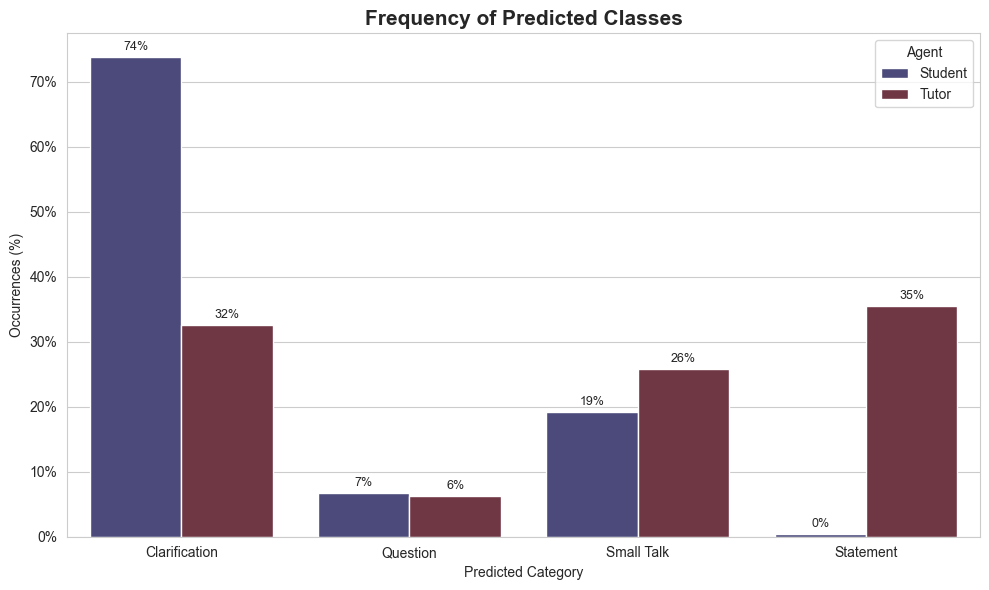

In [4]:
# Summary table
summary = viz.create_summary_table(
    df=annotated_df,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg"
)

print(summary)

# Simple bar plot visualising the table
viz.plot_category_bars(
    df=annotated_df,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    use_percent=True,
    title="Frequency of Predicted Classes"
)



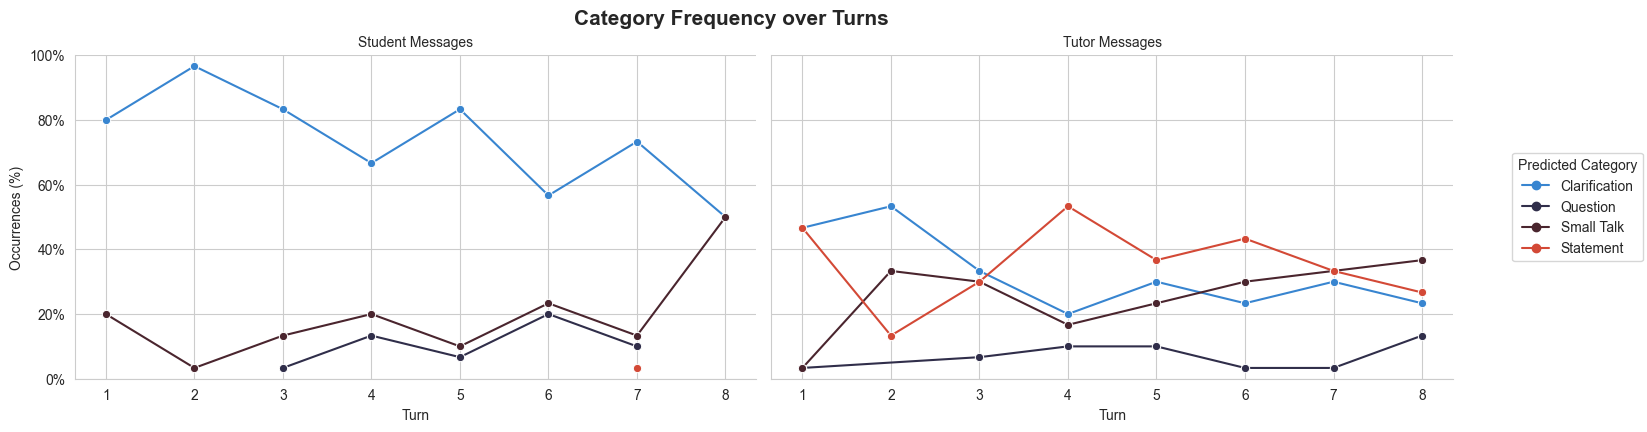

In [ ]:
# Plot category distribution over turns
viz.plot_turn_trends(
    df=annotated_df,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    title="Category Frequencies over Turns",
    show_ci=False,
)



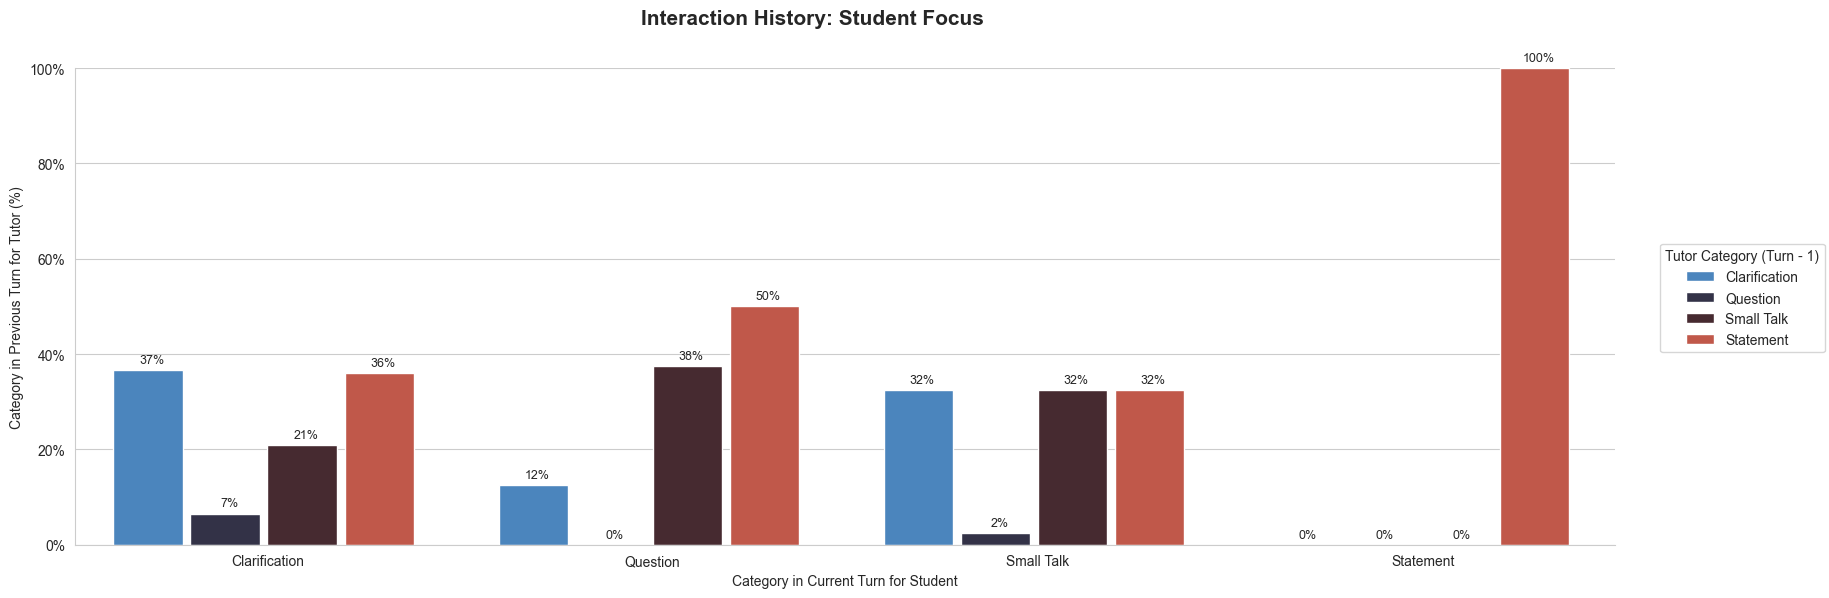

In [7]:
viz.plot_history_interaction(
    df=annotated_df,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="student",
    use_percent=True
)


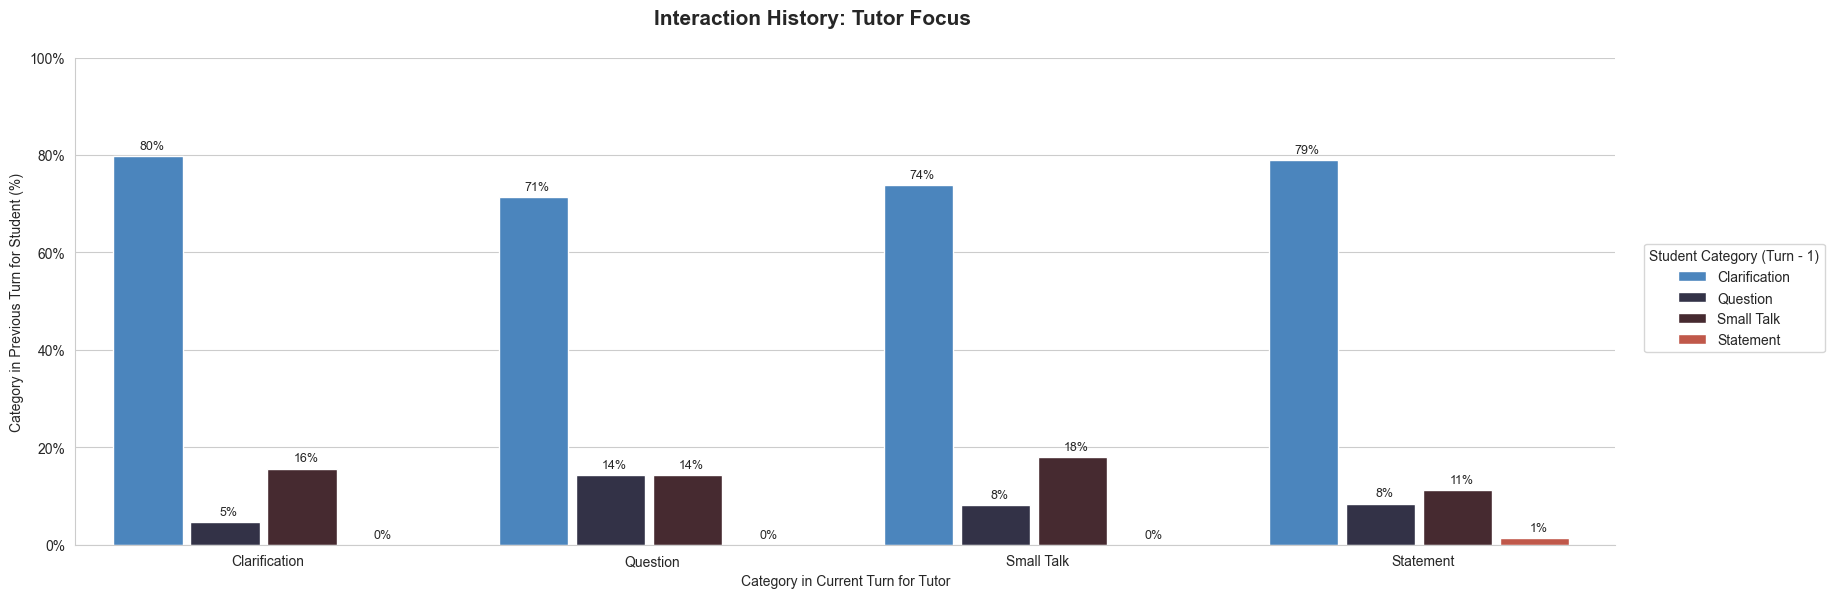

In [9]:
viz.plot_history_interaction(
    df=annotated_df,
    student_col="predicted_labels_student_msg",
    tutor_col="predicted_labels_tutor_msg",
    focus_agent="tutor",
    use_percent=True
)



Everything above is for all students in the 'English Course', but if of interested or fewer samples, a user could run this on a filtered dataframe of only one student and directly see interactions between student and tutor 